In [178]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.sparse import kron, identity, csr_matrix, lil_matrix
from scipy.sparse.linalg import eigsh, eigs
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace, entropy_vn
from tqdm import tqdm
from itertools import product
from functools import reduce
import torch
import torch.optim as optim
from torch.autograd import Variable
import sympy as sp

In [150]:
def pauli_x():
    """Pauli X matrix."""
    return np.array([[0, 1], [1, 0]])

def pauli_z():
    """Pauli Z matrix."""
    return np.array([[1, 0], [0, -1]])

def icosahedral_bonds(): #12 vertices
    """
    Defines the connectivity of a true 12-vertex icosahedral molecular structure.
    
    Returns:
        list of tuples: Each tuple (i, j) represents a bond between spin i and spin j.
    """
    bonds = [
        (0, 2), (0, 4), (0, 5), (0, 8), (0, 9),
        (1, 3), (1, 6), (1, 7), (1, 10), (1, 11),
        (2, 6), (2, 7), (2, 8), (2, 9), (3, 4),
        (3, 5), (3, 10), (3, 11), (4, 5), (4, 8),
        (4, 10), (5, 9), (5, 11), (6, 7), (6, 8),
        (6, 10), (7, 9), (7, 11), (8, 10), (9, 11)
    ]
    return bonds


def transverse_field_ising_icosahedral(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model on an icosahedral molecular structure.
    
    Parameters:
        N (int): Number of spins (should match the icosahedral molecule, typically N=20).
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 12:
        raise ValueError("Icosahedral molecules typically have N = 12 sites.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    X = csr_matrix(pauli_x())
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)
    
    # Get icosahedral bonds
    bonds = icosahedral_bonds()
    
    # Interaction term: -J * sigma_i^x * sigma_j^x for icosahedral connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

def transverse_field_ising_icosahedral_dense(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model in dense format.
    
    Parameters:
        N (int): Number of spins.
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (np.ndarray): The Hamiltonian matrix in dense format.
    """
    # Pauli matrices
    X = pauli_x()
    Z = pauli_z()
    I = np.eye(2)
    
    # Initialize the Hamiltonian
    H = np.zeros((2**N, 2**N), dtype=np.float64)

     # Get icosahedral bonds
    bonds = icosahedral_bonds()
    
    # Interaction term: -J * sigma_i^x * sigma_j^x for icosahedral connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

#######################################################################################################################

'''
def partial_trace_qubit(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits."""
    keep_dims = np.prod([dims[i] for i in keep])
    trace_dims = np.prod([dims[i] for i in range(len(dims)) if i not in keep])
    rho = rho.reshape([keep_dims, trace_dims, keep_dims, trace_dims])
    return np.trace(rho, axis1=1, axis2=3).reshape([keep_dims, keep_dims])

def partial_trace_qubit_torch(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits using PyTorch."""
    keep_dims = torch.prod(torch.tensor([dims[i] for i in keep]))
    trace_dims = torch.prod(torch.tensor([dims[i] for i in range(len(dims)) if i not in keep]))
    rho = rho.view(keep_dims, trace_dims, keep_dims, trace_dims)
    # Compute the partial trace
    traced_rho = torch.zeros((keep_dims, keep_dims), dtype=rho.dtype)
    for i in range(trace_dims):
        traced_rho += rho[:, i, :, i]
    #return traced_rho.view(keep_dims, keep_dims)
    return traced_rho'''

def isket_numpy(arr):
    """
    Check if a NumPy array is a ket (column vector).

    Parameters:
    - arr: np.ndarray, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_numpy(Q, sel, dims): # numpy function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using NumPy.

    Parameters:
    - Q: numpy object, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - numpy object, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = np.asarray(dims[0], dtype=np.int32).ravel()
    nd = len(rd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = np.array([sel])
    else:
        sel = np.asarray(sel)
    sel = list(np.sort(sel))
    
    # Dimensions of the subsystems to keep
    dkeep = (rd[sel]).tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(np.arange(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = (rd[qtrace]).tolist()
    
    # Reshape the density matrix or state vector
    rd = list(rd)
    if isket_numpy(Q):
        # Reshape and transpose for state vector
        vmat = (Q
                .reshape(rd)
                .transpose(sel + qtrace)
                .reshape([np.prod(dkeep), np.prod(dtrace)]))
        # Compute the reduced density matrix
        rhomat = vmat.dot(vmat.conj().T)
    else:
        # Reshape and transpose for density matrix
        rhomat = np.trace(Q
                          .reshape(rd + rd)
                          .transpose(qtrace + [nd + q for q in qtrace] +
                                     sel + [nd + q for q in sel])
                          .reshape([np.prod(dtrace),
                                    np.prod(dtrace),
                                    np.prod(dkeep),
                                    np.prod(dkeep)]))
    return rhomat

def isket_torch(arr):
    """
    Check if a PyTorch tensor is a ket (column vector).

    Parameters:
    - arr: torch.Tensor, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, torch.Tensor):
        raise ValueError("Input must be a PyTorch tensor")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_torch(Q, sel, dims): # torch function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using PyTorch.

    Parameters:
    - Q: torch.Tensor, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - torch.Tensor, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = torch.tensor(dims[0], dtype=torch.int32).flatten()
    nd = len(rd)
    #print("rd", rd)
    #print("nd", nd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = torch.tensor([sel])
    else:
        sel = torch.tensor(sel)
    sel = torch.sort(sel).values.tolist()
    
    # Dimensions of the subsystems to keep
    dkeep = rd[sel].tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(range(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = rd[qtrace].tolist()
    
    # Reshape the density matrix or state vector
    rd = rd.tolist()
    if isket_torch(Q):
        # Reshape and transpose for state vector
        reshaped_Q = Q.reshape(rd)
        #print(reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(sel + qtrace)
        #print(transposed_Q.shape)
        vmat = transposed_Q.reshape([torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dtrace))])
        #print(vmat.shape)
        # Compute the reduced density matrix
        rhomat = vmat @ vmat.conj().T
        #print(rhomat.shape)
    else:
        # Reshape and transpose for density matrix
        reshaped_Q = Q.reshape(rd + rd)
        #print("reshaped_Q", reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(qtrace + [nd + q for q in qtrace] + sel + [nd + q for q in sel])
        #print("transposed_Q", transposed_Q.shape)
        reshaped_transposed_Q = transposed_Q.reshape([torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))])
        #print("reshaped_transposed_Q", reshaped_transposed_Q.shape)
        #rhomat = torch.trace(reshaped_transposed_Q)
        rhomat = torch.einsum('iikl->kl', reshaped_transposed_Q)
        # Trace out the first two dimensions
        #rhomat = torch.zeros((torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))), dtype=Q.dtype)
        #for i in range(reshaped_transposed_Q.shape[0]):
        #    for j in range(reshaped_transposed_Q.shape[1]):
        #        rhomat += reshaped_transposed_Q[i, j, :, :]
        #print("rhomat", rhomat.shape)
    return rhomat

def entanglement_entropy(psi, subsystem_size, total_size):

    '''Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.'''
    
    psi_matrix =  np.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_numpy(psi_matrix, list(range(subsystem_size)), [[2]*total_size, [2]*total_size])  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch(psi, subsystem_size, total_size):
    """
    Computes the bipartite entanglement entropy of a pure state using PyTorch.

    Parameters:
    - psi: torch.Tensor (complex), the wavefunction (state vector) of the full system.
    - subsystem_size: int, the number of qubits in subsystem A.
    - total_size: int, the total number of qubits in the system.

    Returns:
    - torch.Tensor (scalar), the von Neumann entanglement entropy S_A.
    """

    if not isinstance(psi, torch.Tensor):
        psi = torch.tensor(psi, dtype=torch.complex64)
    
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Compute the density matrix |psi><psi|
    psi_matrix = torch.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_torch(psi_matrix, list(range(subsystem_size)), [[2] * total_size, [2] * total_size])  # Partial trace over B

    #rho_A = rho_A.to(dtype=torch.float64)
    
    # Compute eigenvalues of rho_A
    eigvals = torch.linalg.eigvalsh(rho_A)

    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigvals = eigvals[eigvals > 0]

    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -torch.sum(eigvals * torch.log2(eigvals))

    return entropy


def entanglement_entropy_qutip(psi, subsystem_size, total_size):
    
    # Convert the wavefunction to a QuTiP Qobj
    density_matrix = np.outer(psi, psi.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*total_size, [2]*total_size])

    rho_A = ptrace(density_matrix_qobj, list(range(subsystem_size)))
    # Compute the von Neumann entropy S_A
    entropy = entropy_vn(rho_A, base=2)
    
    return entropy

def entanglement_entropy_np_ptrace(rdm):
    # rdm already computed and converted to numpy
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rdm)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch_ptrace(rdm):

    eigvals = torch.linalg.eigvalsh(rdm)
    eigvals = eigvals[eigvals > 0]
    entropy = -torch.sum(eigvals * torch.log2(eigvals))
    return entropy


def entanglement_entropy_qutip_torch(psi, N):
    """
    Compute the von Neumann entanglement entropy using qutip.

    Parameters:
    - psi: torch.Tensor (complex), state vector of a quantum system.
    - N: int, total number of qubits.

    Returns:
    - torch.Tensor (scalar), von Neumann entropy.
    """
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Convert PyTorch tensor to NumPy for QuTiP
    psi_np = psi.detach().numpy()

    rho_np = np.outer(psi_np, psi_np.conj())
    rho_qobj = Qobj(rho_np, dims=[[2] * N, [2] * N])

    rho_A = ptrace(rho_qobj, list(range(N // 2)))

    # Compute von Neumann entropy
    entropy = entropy_vn(rho_A, base=2)  # Compute in log base 2

    # Convert back to PyTorch tensor to allow gradient flow
    return torch.tensor(entropy, dtype=torch.float32, requires_grad=True)

#######################################################################################################################

# Define the linear combination function
def linear_combination(coeffs, psis):
    # Ensure psis are PyTorch tensors
    psis_torch = [torch.tensor(psi, dtype=torch.complex64) if not isinstance(psi, torch.Tensor) else psi for psi in psis]
    
    # Compute the linear combination in PyTorch
    psi_torch = sum(c * psi for c, psi in zip(coeffs, psis_torch))
    
    return psi_torch

# Define the linear combination function
def linear_combination_outer(coeffs, outs):
    # Ensure outs are PyTorch tensors
    outs_torch = [torch.tensor(out, dtype=torch.complex64) if not isinstance(out, torch.Tensor) else out for out in outs]
    torch_coeffs = torch.tensor(coeffs, dtype=torch.complex64)

    # Compute the PyTorch tensor of out_coeffs which is the product of all possible combinations of c_i^* times c_j
    out_coeffs = torch.zeros((len(torch_coeffs), len(torch_coeffs)), dtype=torch.complex64)
    for i in range(len(torch_coeffs)):
        for j in range(len(torch_coeffs)):
            out_coeffs[i, j] = torch.conj(torch_coeffs[i]) * torch_coeffs[j]
    
    # Compute the linear combination in PyTorch
    lin_torch = sum(out_coeffs[i, j] * outs_torch[i] for i in range(len(coeffs)) for j in range(len(coeffs)))
    
    return lin_torch

# Define the linear combination function
def linear_combination_np(coeffs, psis):
    # Ensure psis are numpy tensors
    psi_np = [np.array(psi) for psi in psis]
    # Compute the linear combination in PyTorch
    psi = sum(c * psi for c, psi in zip(coeffs, psis))
    
    return psi

In [3]:
N = 12  # Number of spins
J = 1.0  # Interaction strength
h = 3.0  # Transverse field strength # this is the value in the paper. maybe try  other values too, including the critical value one (h=J=1)

# Assuming transverse_field_ising is defined and returns a sparse Hermitian matrix
H = transverse_field_ising_icosahedral(N, J, h)

#print(f"Hamiltonian shape: {H.shape}")
#print(f"Non-zero elements in H: {H.nnz}")

In [6]:
# All eigenvalues of H
# Compute all eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray())

print(f"Eigenvalues of H: {np.sort(eigenvalues)}")

Eigenvalues of H: [-37.9456425  -33.85228906 -33.85228906 ...  36.38287836  40.95956435
  41.28675302]


In [ ]:
# 4/5 spins rdm - qutip

min_eigenvalues = []
min_rdms = []
rdm_eigenvalues = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out qubits
    #keep_qubits = [2, 8, 4, 5, 9] # pentagon around 0
    keep_qubits = [0, 4, 5, 9]  #, 11]  # 2 adjacent triangular plaquettes
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms.append(traced_out_density_matrix_dense) #store the scarred rdms - step needed for optimization
        rdm_eigenvalues.append(eigenvalues_traced) #store the eigenvalues of the scarred rdms

100%|██████████| 4096/4096 [23:21<00:00,  2.92it/s]


In [47]:
# print rdm rank + rdm + rdm eigenvalues for non scarred points - p.e. last state in the for loop

print(eigenvalues_traced)

print(np.linalg.matrix_rank(traced_out_density_matrix_dense))

# Count entries of eigenvalues_traced that are greater than 1e-16
countf = np.sum(eigenvalues_traced > 1e-16)
print(countf)

# rank is full - 16 for 4 spins or 32 for 5 spins

[2.52072748e-07 2.71824234e-07 1.13261257e-06 1.49306310e-06
 2.59526365e-06 2.03905777e-05 6.00362121e-05 9.29651824e-05
 1.58486100e-04 2.23574437e-04 2.58846360e-04 2.05605176e-03
 3.40451665e-03 4.96257249e-03 3.10970240e-01 6.77786576e-01]
16
16


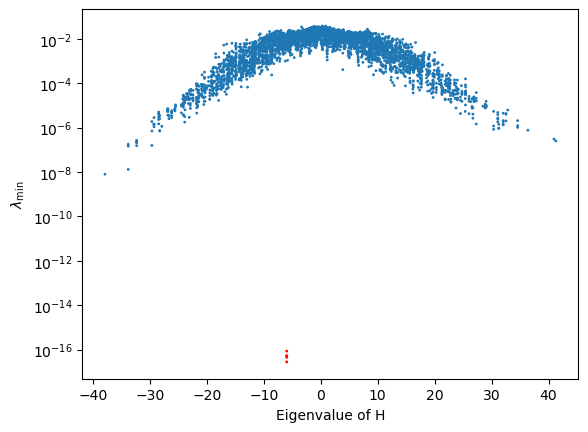

In [48]:
#Define the threshold - qutip
threshold = 1e-16
min_eigenvalues = np.array(min_eigenvalues)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

In [49]:
# Find indices of red points - qutip
red_indices = [i for i, y in enumerate(min_eigenvalues) if y < threshold]
print(f'Indices of red points: {red_indices}')

red_eigenvectors = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms[i])}')
    red_eigenvectors.append(eigenvectors[:, ind])

for i in range(len(red_indices)):
    for j in range(len(red_indices)):
        idx1, idx2 = red_indices[i], red_indices[j]
        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues[i] - eigenvalues of the scarred rdms - that are non-zero
counts = [np.sum(eigenvalues > 1e-16) for eigenvalues in rdm_eigenvalues]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts}')

Indices of red points: [1266, 1267, 1268, 1269, 1270]
0 1266
Eigenvalue: -6.000000000000003, rdm Minimum Eigenvalue: -5.068389397934375e-17
Eigenvector 1266: rdm rank: 11
1 1267
Eigenvalue: -6.0, rdm Minimum Eigenvalue: -2.7795075765071667e-17
Eigenvector 1267: rdm rank: 11
2 1268
Eigenvalue: -6.0, rdm Minimum Eigenvalue: -8.519229768198621e-17
Eigenvector 1268: rdm rank: 11
3 1269
Eigenvalue: -5.999999999999997, rdm Minimum Eigenvalue: -5.305424579531258e-17
Eigenvector 1269: rdm rank: 11
4 1270
Eigenvalue: -5.9999999999999964, rdm Minimum Eigenvalue: -4.475935646746779e-17
Eigenvector 1270: rdm rank: 11
Dot product between eigenvectors 1266 and 1266: 0.9999999999999998
Dot product between eigenvectors 1266 and 1267: -7.37257477290143e-17
Dot product between eigenvectors 1266 and 1268: 2.47198095326695e-17
Dot product between eigenvectors 1266 and 1269: 3.469446951953614e-17
Dot product between eigenvectors 1266 and 1270: -2.0816681711721685e-17
Dot product between eigenvectors 1267 a

In [ ]:
# 4/5 spins rdm - numpy

min_eigenvalues_np = []
min_rdms_np =[]
rdm_eigenvalues_np = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

    # Trace out qubits
    #keep_qubits = [2, 8, 4, 5, 9] # pentagon around 0
    keep_qubits = [0, 4, 5, 9]  # 2 adjacent triangular plaquettes
    traced_out_density_matrix = ptrace_numpy(density_matrix, keep_qubits, [[2]*N, [2]*N])

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues_np.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_np.append(traced_out_density_matrix) #store the scarred rdms - step needed for optimization
        rdm_eigenvalues_np.append(eigenvalues_traced) #store the eigenvalues of the scarred rdms

  0%|          | 0/4096 [00:00<?, ?it/s]

100%|██████████| 4096/4096 [11:19<00:00,  6.03it/s]


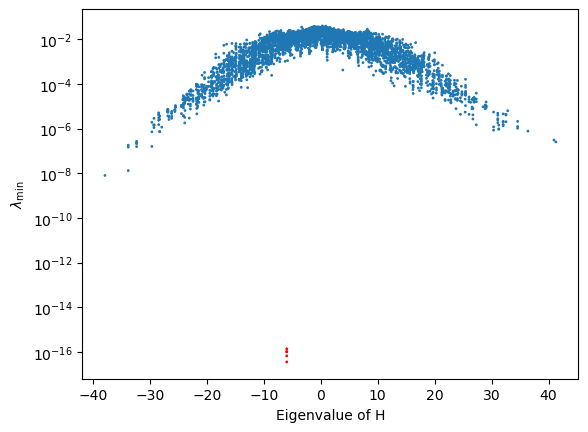

In [ ]:
# numpy

# Define the threshold
threshold = 1e-16
min_eigenvalues_np = np.array(min_eigenvalues_np)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_np if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues_np), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

In [36]:
# Find indices of red points - numpy
red_indices_np = [i for i, y in enumerate(min_eigenvalues_np) if y < threshold]
print(f'Indices of red points: {red_indices_np}')

red_eigenvectors_np = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices_np):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_np[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms_np[i])}')
    red_eigenvectors_np.append(eigenvectors[:, ind])

for i in range(len(red_indices_np)):
    for j in range(len(red_indices_np)):
        idx1, idx2 = red_indices_np[i], red_indices_np[j]
        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues_np[i] - eigenvalues of the scarred rdms - that are non-zero
counts_np = [np.sum(eigenvalues > 1e-16) for eigenvalues in rdm_eigenvalues_np]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts_np}')

Indices of red points: [1266, 1267, 1268, 1269, 1270]
0 1266
Eigenvalue: -6.000000000000003, rdm Minimum Eigenvalue: -6.848310298415013e-17
Eigenvector 1266: rdm rank: 11
1 1267
Eigenvalue: -6.0, rdm Minimum Eigenvalue: -1.0675254868572681e-16
Eigenvector 1267: rdm rank: 11
2 1268
Eigenvalue: -6.0, rdm Minimum Eigenvalue: -1.4123837423102115e-16
Eigenvector 1268: rdm rank: 11
3 1269
Eigenvalue: -5.999999999999997, rdm Minimum Eigenvalue: -1.0430446079050335e-16
Eigenvector 1269: rdm rank: 11
4 1270
Eigenvalue: -5.9999999999999964, rdm Minimum Eigenvalue: -3.6736685350324906e-17
Eigenvector 1270: rdm rank: 11
Dot product between eigenvectors 1266 and 1266: 0.9999999999999998
Dot product between eigenvectors 1266 and 1267: -7.37257477290143e-17
Dot product between eigenvectors 1266 and 1268: 2.47198095326695e-17
Dot product between eigenvectors 1266 and 1269: 3.469446951953614e-17
Dot product between eigenvectors 1266 and 1270: -2.0816681711721685e-17
Dot product between eigenvectors 126

In [ ]:
# 4/5 spins rdm - torch

min_eigenvalues_to = []
min_rdms_to = []
rdm_eigenvalues_to = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    min_eigenvector_torch = torch.tensor(min_eigenvector, dtype=torch.float64)
    density_matrix = torch.outer(min_eigenvector_torch, min_eigenvector_torch.conj())

    # Trace out qubits
    # keep_qubits = [2, 8, 4, 5, 9] # pentagon around 0
    keep_qubits = [0, 4, 5, 9]  # 2 adjacent triangular plaquettes
    traced_out_density_matrix = ptrace_torch(density_matrix, keep_qubits, [[2] * N, [2] * N])
    traced_out_density_matrix = torch.tensor(traced_out_density_matrix, dtype=torch.float64) # necessary step to ensure that the scarred states have lambda_min of the correct order - <1e-16 

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = torch.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = torch.min(eigenvalues_traced).item()
    min_eigenvalues_to.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_to.append(traced_out_density_matrix.detach().cpu().numpy())  # store the scarred rdms - step needed for optimization
        rdm_eigenvalues_to.append(eigenvalues_traced.detach().cpu().numpy()) # store the eigenvalues of the scarred rdms

  0%|          | 0/4096 [00:00<?, ?it/s]C:\Users\camipolv\AppData\Local\Temp\ipykernel_6972\2851404178.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  traced_out_density_matrix = torch.tensor(traced_out_density_matrix, dtype=torch.float64)
100%|██████████| 4096/4096 [04:55<00:00, 13.87it/s]


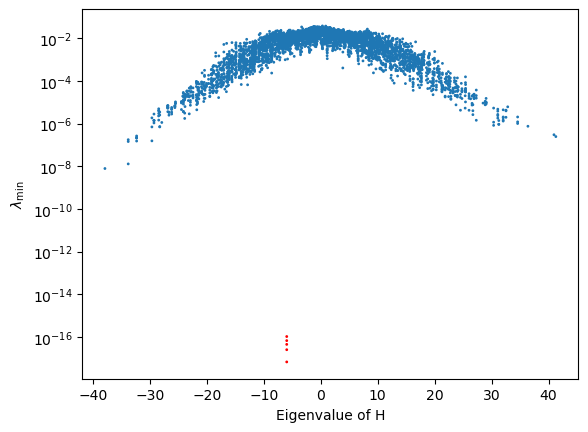

In [41]:
#torch

# Define the threshold
threshold = 1e-16
min_eigenvalues_to = np.array(min_eigenvalues_to)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_to if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_to]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues_to), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

In [51]:
# Find indices of red points - torch
red_indices_to = [i for i, y in enumerate(min_eigenvalues_to) if y < threshold]
print(f'Indices of red points: {red_indices_to}')

red_eigenvectors_to = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices_to):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_to[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms_to[i])}')
    red_eigenvectors_to.append(eigenvectors[:, ind])

for i in range(len(red_indices_to)):
    for j in range(len(red_indices_to)):
        idx1, idx2 = red_indices_to[i], red_indices_to[j]
        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues_to[i] - eigenvalues of the scarred rdms - that are non-zero
counts_to = [np.sum(eigenvalues > 1e-15) for eigenvalues in rdm_eigenvalues_to]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts_to}')

Indices of red points: [1266, 1267, 1268, 1269, 1270]
0 1266
Eigenvalue: -6.000000000000003, rdm Minimum Eigenvalue: -2.5691914697921708e-17
Eigenvector 1266: rdm rank: 11
1 1267
Eigenvalue: -6.0, rdm Minimum Eigenvalue: -1.0655905837812562e-16
Eigenvector 1267: rdm rank: 11
2 1268
Eigenvalue: -6.0, rdm Minimum Eigenvalue: -4.5646814605354034e-17
Eigenvector 1268: rdm rank: 11
3 1269
Eigenvalue: -5.999999999999997, rdm Minimum Eigenvalue: -6.86966170756953e-18
Eigenvector 1269: rdm rank: 11
4 1270
Eigenvalue: -5.9999999999999964, rdm Minimum Eigenvalue: -6.850916130925522e-17
Eigenvector 1270: rdm rank: 11
Dot product between eigenvectors 1266 and 1266: 0.9999999999999998
Dot product between eigenvectors 1266 and 1267: -7.37257477290143e-17
Dot product between eigenvectors 1266 and 1268: 2.47198095326695e-17
Dot product between eigenvectors 1266 and 1269: 3.469446951953614e-17
Dot product between eigenvectors 1266 and 1270: -2.0816681711721685e-17
Dot product between eigenvectors 1267 

In [ ]:
# Generate random complex coefficients
random_coeffs = np.random.rand(len(red_indices)) + 1j* np.random.rand(len(red_indices))

# Normalize the coefficients
random_coeffs /= np.linalg.norm(random_coeffs)
print(random_coeffs)

print("coeffs norm",sum(np.abs(random_coeffs)**2))

# Define random scar state from 5 scarred states using random coefficients
rnd_scar = np.sum(eigenvectors[:, red_indices] * random_coeffs, axis=1)

print(len(rnd_scar))

# Save eigenvalues corresponding to red indices into a numpy array
red_eigenvalues = np.array([eigenvalues[i] for i in red_indices])

[0.19335989+0.23178505j 0.42755998+0.38229825j 0.16310541+0.40999529j
 0.30124627+0.43376415j 0.20773522+0.25134453j]
coeffs norm 1.0000000000000004
4096


In [ ]:
# Count the number of zero entries
num_zeros = np.count_nonzero((rnd_scar.real < 1e-16) & (rnd_scar.imag < 1e-16))
print(f'Number of zero entries: {num_zeros}')

Number of zero entries: 2246


In [214]:
# RANDOM SCAR - RANDOM LINEAR COMBINATION OF SCARRED STATES

rnd_scar = linear_combination_np(random_coeffs, red_eigenvectors)
rnd_scar_entropy = entanglement_entropy(rnd_scar, N // 2, N)
rnd_scar_entropy_qutip = entanglement_entropy_qutip(rnd_scar, N // 2, N)
rnd_scar_entropy_torch = entanglement_entropy_torch(rnd_scar, N // 2, N)
print("Random scar coeffs", random_coeffs)
print(f"Entanglement entropy of random scar state: {rnd_scar_entropy}")
print(f"Entanglement entropy of random scar state (Qutip): {rnd_scar_entropy_qutip}")
print(f"Entanglement entropy of random scar state (PyTorch): {rnd_scar_entropy_torch}")

Random scar coeffs [0.19335989+0.23178505j 0.42755998+0.38229825j 0.16310541+0.40999529j
 0.30124627+0.43376415j 0.20773522+0.25134453j]
Entanglement entropy of random scar state: 4.620070314415163
Entanglement entropy of random scar state (Qutip): 4.620070314415172
Entanglement entropy of random scar state (PyTorch): 4.620068550109863


In [215]:
# Compute bipartite entanglement entropy for all eigenstates in the full Hilbert space
naive_entropies = [entanglement_entropy(eigenvectors[:, i], N // 2, N) for i in tqdm(range(eigenvectors.shape[1]))]
qutip_entropies = [entanglement_entropy_qutip(eigenvectors[:, i], N // 2, N) for i in tqdm(range(eigenvectors.shape[1]))]
torch_entropies = [entanglement_entropy_torch(eigenvectors[:, i], N // 2, N) for i in tqdm(range(eigenvectors.shape[1]))]

  0%|          | 0/4096 [00:00<?, ?it/s]

100%|██████████| 4096/4096 [02:12<00:00, 31.00it/s]


Entropies of red points:
Index: 1266, Entropy: 4.796903469304961
Index: 1267, Entropy: 3.0852083789248104
Index: 1268, Entropy: 4.808932481473971
Index: 1269, Entropy: 4.254512053088167
Index: 1270, Entropy: 4.548550915890671
Random scar entropy: 4.620070314415163


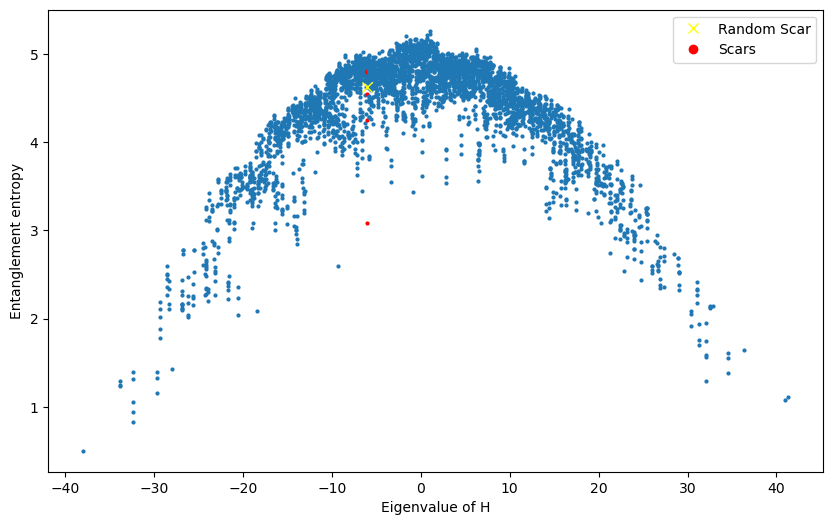

In [216]:
# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {naive_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], naive_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), rnd_scar_entropy, 'x', color='yellow', markersize=7, label='Random Scar')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
plt.legend()
plt.show()

Entropies of red points:
Index: 1266, Entropy: 4.796903469304969
Index: 1267, Entropy: 3.0852083789248215
Index: 1268, Entropy: 4.808932481473981
Index: 1269, Entropy: 4.254512053088176
Index: 1270, Entropy: 4.548550915890681
Random scar entropy: 4.620070314415172


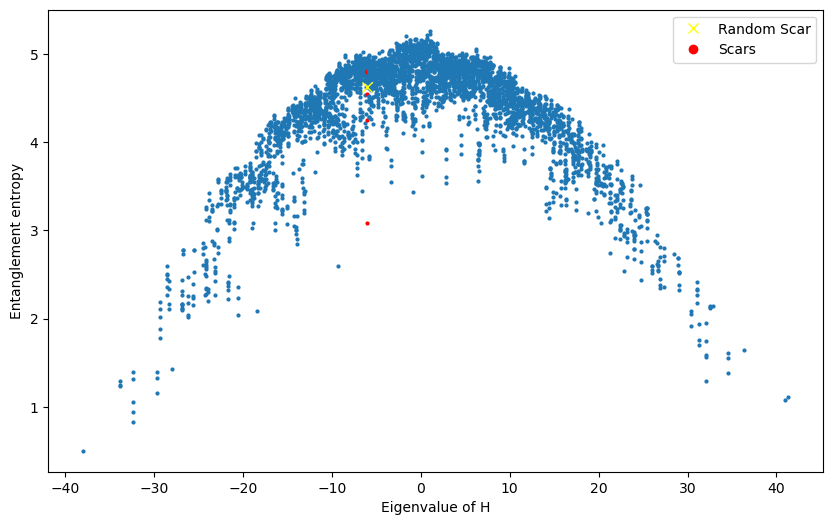

In [217]:
# Compute entanglement entropy for the rnd_scar wavefunction - qutip

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {qutip_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy_qutip}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], qutip_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), rnd_scar_entropy_qutip, 'x', color='yellow', markersize=7, label='Random Scar')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
#plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.legend()
plt.show()

Entropies of red points:
Index: 1266, Entropy: 4.796907424926758
Index: 1267, Entropy: 3.0852091312408447
Index: 1268, Entropy: 4.808933258056641
Index: 1269, Entropy: 4.254512310028076
Index: 1270, Entropy: 4.54855489730835
Random scar entropy: 4.620068550109863


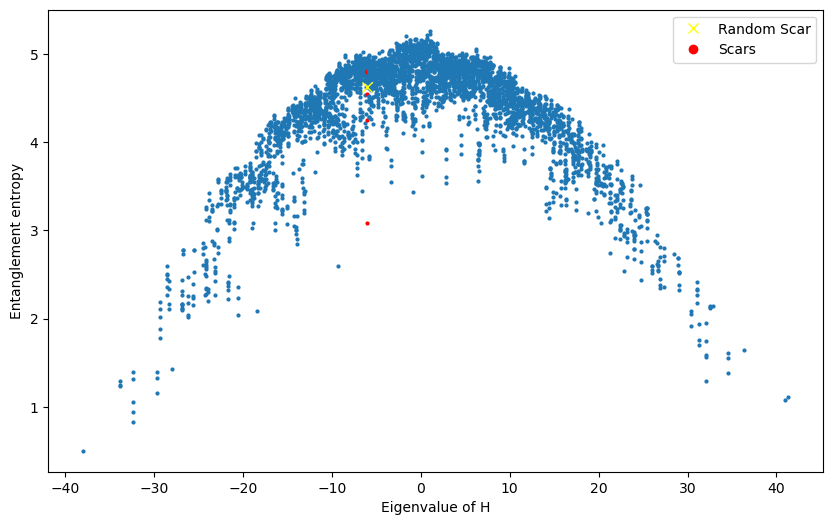

In [218]:
# Compute entanglement entropy for the rnd_scar wavefunction - torch

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {torch_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy_torch}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], torch_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), rnd_scar_entropy_torch, 'x', color='yellow', markersize=7, label='Random Scar')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
#plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.legend()
plt.show()

Entropies of red points:
Index: 1266, Entropy: 4.796903469304961
Index: 1267, Entropy: 3.0852083789248104
Index: 1268, Entropy: 4.808932481473971
Index: 1269, Entropy: 4.254512053088167
Index: 1270, Entropy: 4.548550915890671
Random scar entropy: 4.620070314415163


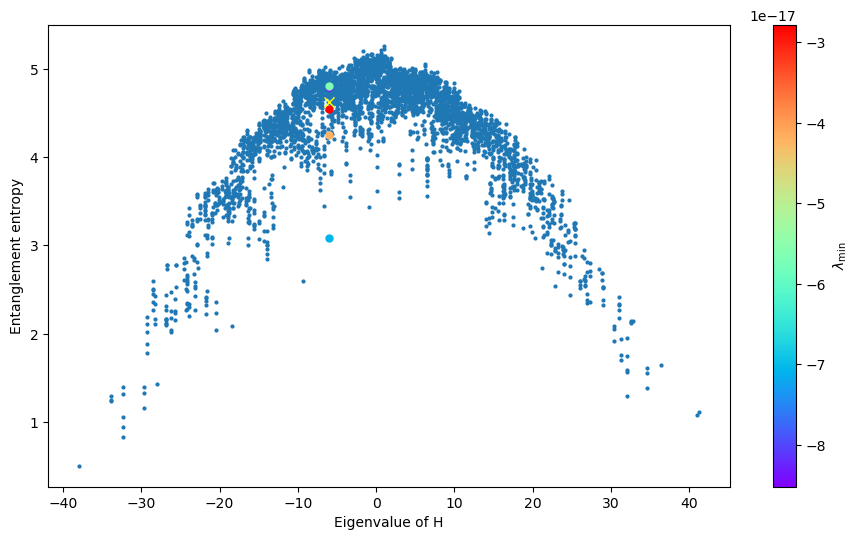

In [219]:
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(red_indices)))

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {naive_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(11, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], naive_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(red_indices):
    handle, = ax.plot(eigenvalues[idx], naive_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(f'λ_min: {float(min_eigenvalues[idx]):.2e}, Entropy: {naive_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
max_scar_handle, = ax.plot(np.mean(red_eigenvalues), rnd_scar_entropy, 'x', color='yellow', markersize=7)
handles.append(max_scar_handle)
labels.append('Max Scar, Entropy: {:.2f}'.format(rnd_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues[idx] for idx in red_indices]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label=r'$\lambda_{\mathrm{min}}$')

ax.set_xlabel('Eigenvalue of H')
ax.set_ylabel('Entanglement entropy')
#ax.set_title('Entanglement entropy as a function of energy eigenvalues')
plt.show()

In [220]:
# Let's look closer at the scar points with the lowest and highest entropy (Indeces: 1267, 1266)

# MIN ENTROPY

lowest_entropy_index = 1267
lowest_entropy_eigenvector = eigenvectors[:, lowest_entropy_index]
entanglement_entropy_value = entanglement_entropy(lowest_entropy_eigenvector, N // 2, N)
print(f'Lowest Entropy Index: {lowest_entropy_index}, Entropy: {entanglement_entropy_value}')   

# Convert the eigenvector to PyTorch tensors for real and imaginary parts
params_real = torch.tensor(lowest_entropy_eigenvector.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(lowest_entropy_eigenvector.imag, dtype=torch.float, requires_grad=True)

print("Initial coeffs, real:", params_real)
print("Initial coeffs, imag:", params_imag)

entanglement_entropy_value = entanglement_entropy_torch(lowest_entropy_eigenvector, N // 2, N)
print(f'Lowest Entropy Index: {lowest_entropy_index}, Entropy: {entanglement_entropy_value}')

# Define coefficients for the linear combination
min_coeffs = np.zeros(len(red_eigenvectors), dtype=np.complex128)  # Initialize all coefficients to 0
min_coeffs[red_indices.index(1267)] = 1  # Ensure the coefficient for index 1267 is explicitly set to 1

# MAX ENTROPY
highest_entropy_index = 1266
highest_entropy_eigenvector = eigenvectors[:, highest_entropy_index]
entanglement_entropy_value = entanglement_entropy(highest_entropy_eigenvector, N // 2, N)
print(f'Highest Entropy Index: {highest_entropy_index}, Entropy: {entanglement_entropy_value}') 

# Convert the eigenvector to PyTorch tensors for real and imaginary parts
params_real = torch.tensor(lowest_entropy_eigenvector.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(lowest_entropy_eigenvector.imag, dtype=torch.float, requires_grad=True)

print("Initial coeffs, real:", params_real)
print("Initial coeffs, imag:", params_imag)

entanglement_entropy_value = entanglement_entropy_torch(highest_entropy_eigenvector, N // 2, N)
print(f'Highest Entropy Index: {highest_entropy_index}, Entropy: {entanglement_entropy_value}')

# Define coefficients for the linear combination
max_coeffs = np.zeros(len(red_eigenvectors), dtype=np.complex128)  # Initialize all coefficients to 0
max_coeffs[red_indices.index(1266)] = 1  # Ensure the coefficient for index 1267 is explicitly set to 1


Lowest Entropy Index: 1267, Entropy: 3.0852083789248104
Initial coeffs, real: tensor([ 0.0000e+00,  5.2879e-17, -4.5073e-17,  ..., -2.3439e-18,
        -1.0659e-17,  3.8318e-18], requires_grad=True)
Initial coeffs, imag: tensor([0., 0., 0.,  ..., 0., 0., 0.], requires_grad=True)
Lowest Entropy Index: 1267, Entropy: 3.0852091312408447
Highest Entropy Index: 1266, Entropy: 4.796903469304961
Initial coeffs, real: tensor([ 0.0000e+00,  5.2879e-17, -4.5073e-17,  ..., -2.3439e-18,
        -1.0659e-17,  3.8318e-18], requires_grad=True)
Initial coeffs, imag: tensor([0., 0., 0.,  ..., 0., 0., 0.], requires_grad=True)
Highest Entropy Index: 1266, Entropy: 4.796907424926758


In [221]:
# Compute torch bipartite ptrace before optimization

outer_products = []
partial_traces = []

red_eigenvectors = list(red_eigenvectors)
print(len(red_eigenvectors))

for i in tqdm(range(len(red_eigenvectors))):
    for j in tqdm(range(len(red_eigenvectors))):
        outer_product = np.outer(red_eigenvectors[i], red_eigenvectors[j].conj())
        outer_products.append(outer_product)

# Convert the list of outer products to a PyTorch tensor
outer_products = torch.tensor(outer_products, dtype=torch.float64)

print(len(outer_products))

# Compute the partial trace for each element in outer_products
for op in tqdm(outer_products):
    density_matrix_torch = torch.tensor(op, dtype=torch.float64)
    ptrace_op = ptrace_torch(op, list(range(N // 2)), [[2]*N, [2]*N])  # tracing out half system because I'm interested in bipartite entanglement entropy
    p_trace_op = torch.tensor(ptrace_op, dtype=torch.float64) #  necessary here?
    partial_traces.append(ptrace_op)

# Print the partial traces
for idx, pt in enumerate(partial_traces):
    print(f"Partial trace of outer product {idx}:\n{pt}\n")

5


100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


25


  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\camipolv\AppData\Local\Temp\ipykernel_6972\3672071811.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  density_matrix_torch = torch.tensor(op, dtype=torch.float64)
C:\Users\camipolv\AppData\Local\Temp\ipykernel_6972\3672071811.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p_trace_op = torch.tensor(ptrace_op, dtype=torch.float64) #  necessary here?
100%|██████████| 25/25 [00:00<00:00, 45.82it/s]

Partial trace of outer product 0:
tensor([[ 3.9161e-26,  4.3206e-17,  4.6385e-18,  ...,  3.5233e-18,
          3.9306e-19, -5.6586e-29],
        [ 4.3206e-17,  2.9496e-03, -1.0624e-15,  ...,  3.5416e-16,
         -9.0615e-16, -4.0756e-19],
        [ 4.6385e-18, -1.0624e-15,  1.5650e-02,  ..., -1.1817e-15,
          1.4766e-15,  2.0323e-18],
        ...,
        [ 3.5233e-18,  3.5416e-16, -1.1817e-15,  ...,  1.5650e-02,
         -3.7669e-16,  9.2734e-18],
        [ 3.9306e-19, -9.0615e-16,  1.4766e-15,  ..., -3.7669e-16,
          2.9496e-03,  8.4980e-18],
        [-5.6586e-29, -4.0756e-19,  2.0323e-18,  ...,  9.2734e-18,
          8.4980e-18,  3.5311e-27]], dtype=torch.float64)

Partial trace of outer product 1:
tensor([[ 1.0742e-27, -9.1522e-17,  1.7868e-18,  ...,  4.7050e-19,
         -5.1581e-18, -4.6661e-29],
        [ 5.2128e-17, -4.9290e-03,  2.1985e-16,  ...,  5.3642e-17,
          3.0192e-15, -1.1980e-19],
        [-5.7665e-17,  2.4805e-15,  3.2812e-03,  ..., -1.0696e-17,
     

Initial Entropy: 3.0852088928222656
Coeffs norm: 0.99999994
Entropy: 3.0852088928222656
Coeffs: [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
Coeffs norm: 0.99999994
Entropy: 2.9968011379241943
Coeffs: [-0.009998 +0.j  0.9998001+0.j -0.009998 +0.j -0.009998 +0.j
 -0.009998 +0.j]
Coeffs norm: 1.0
Entropy: 2.9056332111358643
Coeffs: [-0.0201325 +0.j  0.99918854+0.j -0.02014239+0.j -0.02013969+0.j
 -0.02014174+0.j]
Coeffs norm: 0.99999994
Entropy: 2.8122901916503906
Coeffs: [-0.03034228+0.j  0.998154  +0.j -0.03037921+0.j -0.03036996+0.j
 -0.03037742+0.j]
Coeffs norm: 0.99999994
Entropy: 2.716939926147461
Coeffs: [-0.04061408+0.j  0.9966856 +0.j -0.04070297+0.j -0.04068278+0.j
 -0.04070026+0.j]
Coeffs norm: 1.0
Entropy: 2.619765520095825
Coeffs: [-0.05093436+0.j  0.994773  +0.j -0.05110868+0.j -0.05107322+0.j
 -0.05110654+0.j]
Coeffs norm: 0.99999994
Entropy: 2.5209600925445557
Coeffs: [-0.06128766+0.j  0.9924063 +0.j -0.06159035+0.j -0.06153605+0.j
 -0.0615922 +0.j]
Coeffs norm: 1.0
Entropy: 2.42

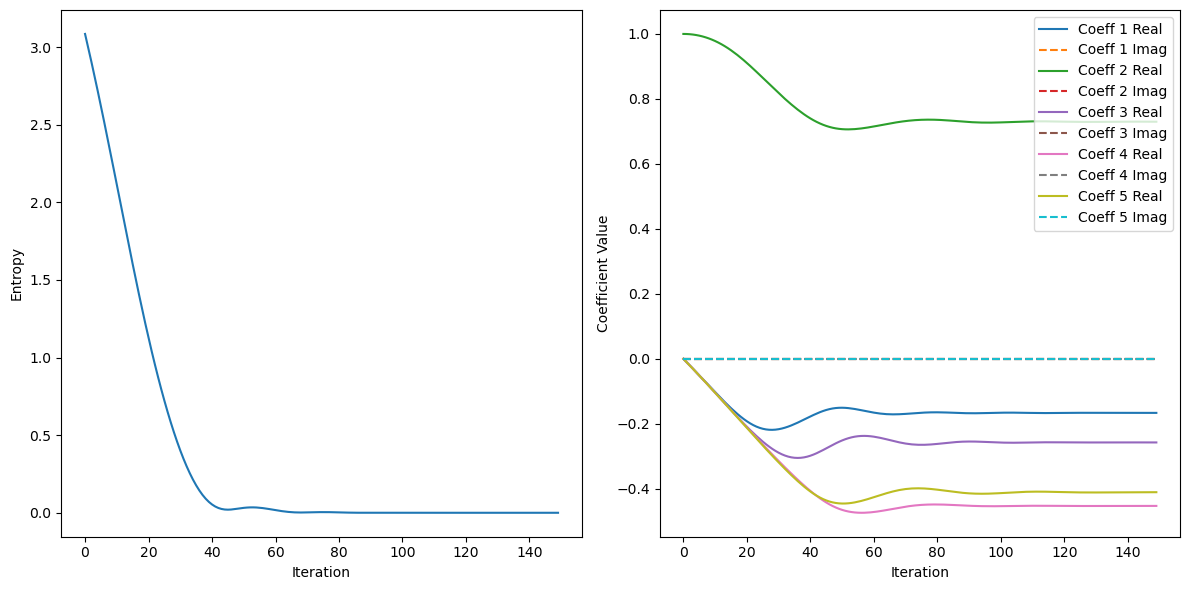

In [222]:
# find entropy min coeffs - everything  has to be in torch

# Initialize parameters for the coefficients with all values equal
#params_real = torch.full((5,), 1/np.sqrt(10), requires_grad=True)
#params_imag = torch.full((5,), 1/np.sqrt(10), requires_grad=True)

# Initialize parameters for the coefficients with random values
#params_real = torch.randn(5, requires_grad=True)
#params_imag = torch.randn(5, requires_grad=True)

# Convert random_coeffs to PyTorch tensors
#params_real = torch.tensor(random_coeffs.real, dtype=torch.float, requires_grad=True)
#params_imag = torch.tensor(random_coeffs.imag, dtype=torch.float, requires_grad=True)

params_real = torch.tensor(min_coeffs.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(min_coeffs.imag, dtype=torch.float, requires_grad=True)

# Compute the linear combination using the defined function
psi = linear_combination(torch.complex(params_real, params_imag), red_eigenvectors)

# if the outer products between scarred states are computed before optimization loop
# ....

# Compute entanglement entropy
entropy = entanglement_entropy_torch(psi, N // 2, N) 
print(f'Initial Entropy: {entropy.item()}')

# Normalize the parameters to ensure the norm is 1
with torch.no_grad():
    norm = torch.norm(torch.complex(params_real, params_imag))
    params_real /= norm
    params_imag /= norm

# Define the optimizer
optimizer = optim.Adam([params_real, params_imag], lr=0.01)

# Lists to store the values of parameters and entropy
coeffs_history_min = []
entropy_history = []

# Optimization loop
num_iterations = 150
for _ in range(num_iterations):
    optimizer.zero_grad()
    
    # Combine real and imaginary parts for the coefficients
    coeffs = torch.complex(params_real, params_imag)
    
    # Normalize coefficients to project them onto the unit sphere
    coeffs = coeffs / torch.norm(coeffs)
    
    # Compute psi
    psi = linear_combination(coeffs, red_eigenvectors)
    
    # Compute entanglement entropy
    entropy = entanglement_entropy_torch(psi, N // 2, N) # it would be better to compute the outer product of the state before the optimization loop. but optimization is not taking too long so it's ok for now
    
    # Backpropagation
    entropy.backward()
    optimizer.step()
    
    # Normalize parameters again to ensure they stay on the unit sphere
    with torch.no_grad():
        norm = torch.norm(torch.complex(params_real, params_imag))
        params_real /= norm
        params_imag /= norm
    print("Coeffs norm:", torch.norm(torch.complex(params_real, params_imag)).detach().cpu().numpy())
    
    print(f'Entropy: {entropy.item()}')
    print(f'Coeffs: {coeffs.detach().cpu().numpy()}')

    # Store the values of parameters and entropy
    coeffs_history_min.append(coeffs.detach().cpu().numpy())
    entropy_history.append(entropy.item())

# Final optimized coefficients
optimized_coeffs = torch.complex(params_real, params_imag)
optimized_coeffs = optimized_coeffs / torch.norm(optimized_coeffs)

print("Optimized coefficients:", optimized_coeffs)

# Plot the value of parameters and entropy as a function of num_iterations
plt.figure(figsize=(12, 6))

# Plot entropy
plt.subplot(1, 2, 1)
plt.plot(entropy_history)
plt.xlabel('Iteration')
plt.ylabel('Entropy')
#plt.title('Entropy vs. Iterations')

# Plot coefficients
plt.subplot(1, 2, 2)
coeffs_history_min = np.array(coeffs_history_min)
for i in range(coeffs_history_min.shape[1]):
    plt.plot(coeffs_history_min[:, i].real, label=f'Coeff {i+1} Real')
    plt.plot(coeffs_history_min[:, i].imag, label=f'Coeff {i+1} Imag', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
#plt.title('Coefficients vs. Iterations')
plt.legend()

plt.tight_layout()
plt.show()

Entropies of red points:
Index: 1266, Entropy: 4.796903469304961
Index: 1267, Entropy: 3.0852083789248104
Index: 1268, Entropy: 4.808932481473971
Index: 1269, Entropy: 4.254512053088167
Index: 1270, Entropy: 4.548550915890671
Min scar entropy: 1.0277677447955816e-06


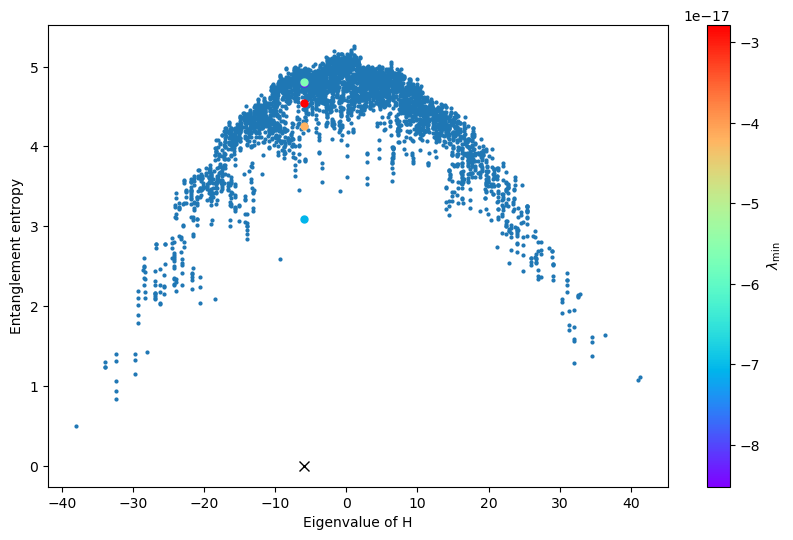

In [223]:
# Compute the max_scar wavefunction using the optimized coefficients (min entropy)
min_scar = linear_combination_np(coeffs_history_min[-1], red_eigenvectors)
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(red_indices)))

# Compute entanglement entropy for the max_scar wavefunction
min_scar_entropy = entanglement_entropy(min_scar, N // 2, N)

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {naive_entropies[i]}')

print(f'Min scar entropy: {min_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], naive_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(red_indices):
    handle, = ax.plot(eigenvalues[idx], naive_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(r'$\lambda_\mathrm{min}$: {float(min_eigenvalues[idx]):.2e}, Entropy: {naive_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
min_scar_handle, = ax.plot(np.mean(eigenvalues[red_indices]), min_scar_entropy, 'x', color='black', markersize=7)
handles.append(min_scar_handle)
labels.append('Min Scar, Entropy: {:.2f}'.format(min_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues[idx] for idx in red_indices]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label=r'$\lambda_{\mathrm{min}}$')

ax.set_xlabel('Eigenvalue of H')
ax.set_ylabel('Entanglement entropy')
plt.show()

Initial coeffs, real tensor([1., 0., 0., 0., 0.], requires_grad=True)
Initial coeffs imag tensor([0., 0., 0., 0., 0.], requires_grad=True)
Initial Entropy: 4.796907424926758
Coeffs norm: 0.99999994
Entropy: 4.796907424926758
Coeffs: [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Coeffs norm: 0.99999994
Entropy: 4.808707237243652
Coeffs: [ 0.9998001+0.j -0.009998 +0.j -0.009998 +0.j -0.009998 +0.j
  0.009998 +0.j]
Coeffs norm: 1.0
Entropy: 4.819498062133789
Coeffs: [ 0.99920094+0.j -0.02010842+0.j -0.02011892+0.j -0.02012533+0.j
  0.01957908+0.j]
Coeffs norm: 1.0
Entropy: 4.8293070793151855
Coeffs: [ 0.9982419 +0.j -0.0302575 +0.j -0.03029546+0.j -0.03032136+0.j
  0.02757676+0.j]
Coeffs norm: 0.9999999
Entropy: 4.838511943817139
Coeffs: [ 0.9970131 +0.j -0.04042974+0.j -0.04051157+0.j -0.04057546+0.j
  0.03229193+0.j]
Coeffs norm: 1.0
Entropy: 4.847689151763916
Coeffs: [ 0.9955819 +0.j -0.05063365+0.j -0.05075967+0.j -0.05087871+0.j
  0.03298163+0.j]
Coeffs norm: 1.0
Entropy: 4.857122421264648
Co

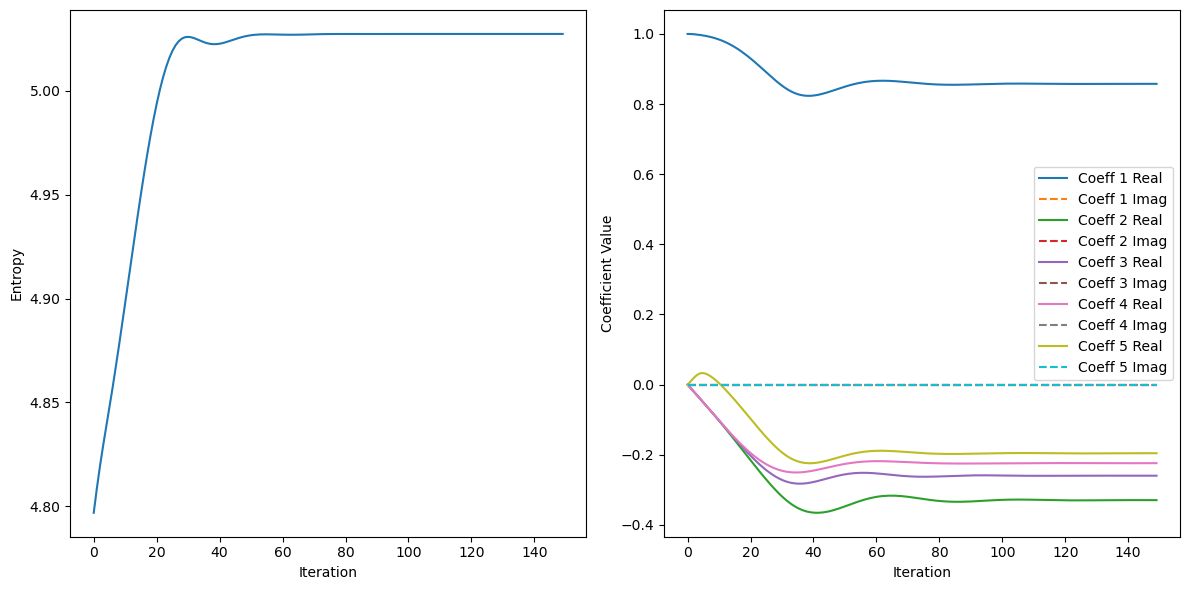

In [224]:
# now find entropy max coeffs - everything  has to be in torch

# Initialize parameters for the coefficients with all values equal
#params_real = torch.full((5,), 1/np.sqrt(10), requires_grad=True)
#params_imag = torch.full((5,), 1/np.sqrt(10), requires_grad=True)

# Initialize parameters for the coefficients with random values
#params_real = torch.randn(5, requires_grad=True)
#params_imag = torch.randn(5, requires_grad=True)

# Convert random_coeffs to PyTorch tensors
#params_real = torch.tensor(random_coeffs.real, dtype=torch.float, requires_grad=True)
#params_imag = torch.tensor(random_coeffs.imag, dtype=torch.float, requires_grad=True)

params_real = torch.tensor(max_coeffs.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(max_coeffs.imag, dtype=torch.float, requires_grad=True)

print("Initial coeffs, real", params_real)
print("Initial coeffs imag",  params_imag)

# Compute psi
psi = linear_combination(torch.complex(params_real, params_imag), red_eigenvectors)

# Compute entanglement entropy
entropy = entanglement_entropy_torch(psi, N // 2, N) 
print(f'Initial Entropy: {entropy.item()}')

# Normalize the parameters to ensure the norm is 1
with torch.no_grad():
    norm = torch.norm(torch.complex(params_real, params_imag))
    params_real /= norm
    params_imag /= norm

# Define the optimizer
optimizer = optim.Adam([params_real, params_imag], lr=0.01)

# Lists to store the values of parameters and entropy
coeffs_history_max = []
entropy_history_max = []

# Optimization loop
num_iterations = 150
for _ in range(num_iterations):
    optimizer.zero_grad()
    
    # Combine real and imaginary parts for the coefficients
    coeffs = torch.complex(params_real, params_imag)
    
    # Normalize coefficients to project them onto the unit sphere
    coeffs = coeffs / torch.norm(coeffs)
    
    # Compute psi
    psi = linear_combination(coeffs, red_eigenvectors)
    
    # Compute - entanglement entropy
    entropy = - entanglement_entropy_torch(psi, N // 2, N) # it would be better to compute the outer product of the state before the optimization loop. but optimization is not taking too long so it's ok for now
    
    # Backpropagation
    entropy.backward()
    optimizer.step()
    
    # Normalize parameters again to ensure they stay on the unit sphere
    with torch.no_grad():
        norm = torch.norm(torch.complex(params_real, params_imag))
        params_real /= norm
        params_imag /= norm
    print("Coeffs norm:", torch.norm(torch.complex(params_real, params_imag)).detach().cpu().numpy())
    
    print(f'Entropy: {abs(entropy.item())}')
    print(f'Coeffs: {coeffs.detach().cpu().numpy()}')

    # Store the values of parameters and entropy
    coeffs_history_max.append(coeffs.detach().cpu().numpy())
    entropy_history_max.append(abs(entropy.item()))

# Final optimized coefficients
optimized_coeffs_max = torch.complex(params_real, params_imag)
optimized_coeffs_max = optimized_coeffs_max / torch.norm(optimized_coeffs_max)

print("Optimized coefficients:", optimized_coeffs_max)

# Plot the value of parameters and entropy as a function of num_iterations
plt.figure(figsize=(12, 6))

# Plot entropy
plt.subplot(1, 2, 1)
plt.plot(np.abs(entropy_history_max))
plt.xlabel('Iteration')
plt.ylabel('Entropy')
#plt.title('Entropy vs. Iterations')

# Plot coefficients
plt.subplot(1, 2, 2)
coeffs_history_max = np.array(coeffs_history_max)
for i in range(coeffs_history_max.shape[1]):
    plt.plot(coeffs_history_max[:, i].real, label=f'Coeff {i+1} Real')
    plt.plot(coeffs_history_max[:, i].imag, label=f'Coeff {i+1} Imag', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
#plt.title('Coefficients vs. Iterations')
plt.legend()

plt.tight_layout()
plt.show()

Entropies of red points:
Index: 1266, Entropy: 4.796903469304961
Index: 1267, Entropy: 3.0852083789248104
Index: 1268, Entropy: 4.808932481473971
Index: 1269, Entropy: 4.254512053088167
Index: 1270, Entropy: 4.548550915890671
Max scar entropy: 5.027332100224289


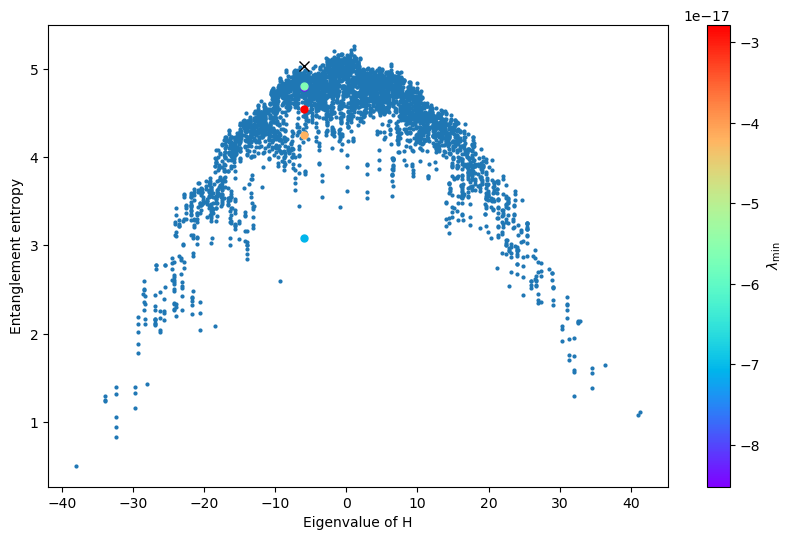

In [225]:
# Compute the max_scar wavefunction using the optimized coefficients (min entropy)
max_scar = linear_combination_np(coeffs_history_max[-1], red_eigenvectors)
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(red_indices)))

# Compute entanglement entropy for the max_scar wavefunction
max_scar_entropy = entanglement_entropy(max_scar, N // 2, N)

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {naive_entropies[i]}')

print(f'Max scar entropy: {max_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], naive_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(red_indices):
    handle, = ax.plot(eigenvalues[idx], naive_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(r'$\lambda_\mathrm{min}$: {float(min_eigenvalues[idx]):.2e}, Entropy: {naive_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
max_scar_handle, = ax.plot(np.mean(eigenvalues[red_indices]), max_scar_entropy, 'x', color='black', markersize=7)
handles.append(max_scar_handle)
labels.append('Max Scar, Entropy: {:.2f}'.format(max_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues[idx] for idx in red_indices]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label=r'$\lambda_{\mathrm{min}}$')

ax.set_xlabel('Eigenvalue of H')
ax.set_ylabel('Entanglement entropy')
#ax.set_title('Entanglement entropy as a function of energy eigenvalues')
#ax.legend(sorted_handles, sorted_labels)
plt.show()

In [226]:
# Look at properties of all of the 5 scars wavefunctions

for i in red_indices:

    print(f'Index: {i}, Energy: {eigenvalues[i]}, Entropy: {naive_entropies[i]}')

    #Count the number of zero entries
    num_zeros = np.count_nonzero((eigenvectors[i].real < 1e-16) & (eigenvectors[i].imag < 1e-16))
    print(f'Number of zero entries: {num_zeros}')

    rho_scar = np.dot(eigenvectors[i], eigenvectors[i].conj().T)
    print("Rank of rho scar i:", np.linalg.matrix_rank(rho_scar))

for i in (i for i in range(N) if i not in red_indices):
    #print(f'Index: {i}, Energy: {eigenvalues[i]}, Entropy: {naive_entropies[i]}')

    #Count the number of zero entries
    num_zeros = np.count_nonzero((eigenvectors[i].real < 1e-16) & (eigenvectors[i].imag < 1e-16))
    print(f'Number of zero entries: {num_zeros}')

Index: 1266, Energy: -6.000000000000003, Entropy: 4.796903469304961
Number of zero entries: 2304
Rank of rho scar i: 1
Index: 1267, Energy: -6.0, Entropy: 3.0852083789248104
Number of zero entries: 2381
Rank of rho scar i: 1
Index: 1268, Energy: -6.0, Entropy: 4.808932481473971
Number of zero entries: 2352
Rank of rho scar i: 1
Index: 1269, Energy: -5.999999999999997, Entropy: 4.254512053088167
Number of zero entries: 2340
Rank of rho scar i: 1
Index: 1270, Energy: -5.9999999999999964, Entropy: 4.548550915890671
Number of zero entries: 2420
Rank of rho scar i: 1
Number of zero entries: 4007
Number of zero entries: 3194
Number of zero entries: 3216
Number of zero entries: 2725
Number of zero entries: 3181
Number of zero entries: 2706
Number of zero entries: 3279
Number of zero entries: 2546
Number of zero entries: 3188
Number of zero entries: 3284
Number of zero entries: 2672
Number of zero entries: 2459


In [227]:
# Look at structure of the wavefunction with these optimal coeffs corresp to min entropy

print(len(min_scar))

#Count the number of zero entries
num_zeros = np.count_nonzero((min_scar.real < 1e-16) & (min_scar.imag < 1e-16))
print(f'Number of zero entries: {num_zeros}')


rho_scar = np.dot(min_scar, min_scar.conj().T)
print("Rank of rho scar:", np.linalg.matrix_rank(rho_scar))

# Reshape psi into a 2^subsystem_size x 2^environment_size matrix
psi_matrix = min_scar.reshape((2**(N // 2), 2**(N // 2)))

# Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
rho_A = np.dot(psi_matrix, psi_matrix.conj().T)  # Partial trace over B

print(np.trace(rho_A))
print(np.trace(rho_A @ rho_A))
print(np.trace(np.dot(rho_A, rho_A)))

# Check if rho_A is Hermitian
is_hermitian = np.allclose(rho_A, rho_A.conj().T)
print(f'Is rho_A Hermitian? {is_hermitian}')

4096
Number of zero entries: 2462
Rank of rho scar: 1
(1.0000001029012564+0j)
(1.0000001288235878+0j)
(1.0000001288235878+0j)
Is rho_A Hermitian? True


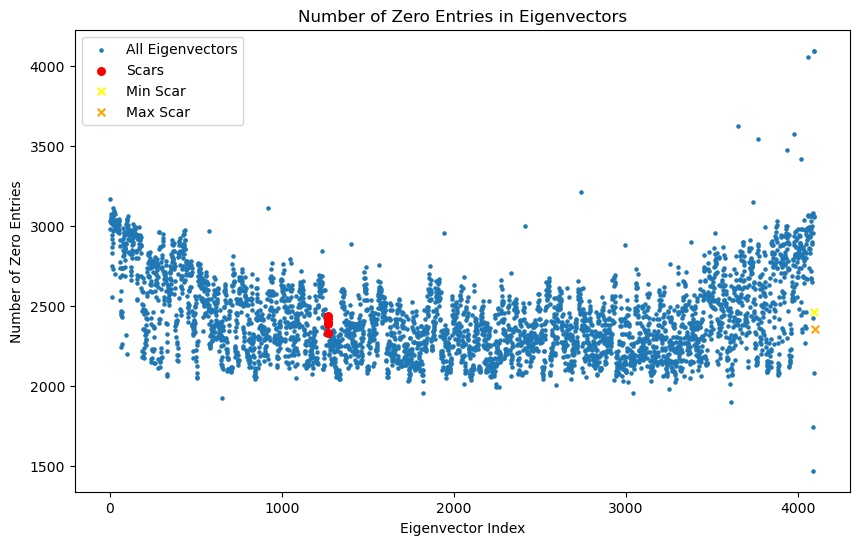

In [ ]:
# Count the number of zero entries for all eigenvectors
num_zeros_all = [np.count_nonzero((eigenvectors[:, i].real < 1e-16) & (eigenvectors[:, i].imag < 1e-16)) for i in range(eigenvectors.shape[1])]

# Count the number of zero entries for red_eigenvectors
num_zeros_red = [np.count_nonzero((red_eigenvectors[i].real < 1e-16) & (red_eigenvectors[i].imag < 1e-16)) for i in range(len(red_eigenvectors))]

# Count the number of zero entries for min_scar and max_scar
num_zeros_min_scar = np.count_nonzero((min_scar.real < 1e-16) & (min_scar.imag < 1e-16))
num_zeros_max_scar = np.count_nonzero((max_scar.real < 1e-16) & (max_scar.imag < 1e-16))

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot all eigenvectors in color 'C0'
plt.scatter(range(len(num_zeros_all)), num_zeros_all, color='C0', label='All Eigenvectors', s=5)

# Highlight red_eigenvectors in red
for i, idx in enumerate(red_indices):
    plt.scatter(idx, num_zeros_red[i], color='red', label='Scars' if i == 0 else "", s=30)

# Mark min_scar and max_scar with yellow and orange crosses - and put them at the end of the plot
plt.scatter(len(num_zeros_all), num_zeros_min_scar, color='yellow', marker='x', s=30, label='Min Scar')
plt.scatter(len(num_zeros_all) + 1, num_zeros_max_scar, color='orange', marker='x', s=30, label='Max Scar')

# Add labels and legend
plt.xlabel('Eigenvector Index')
plt.ylabel('Number of Zero Entries')
plt.legend()
plt.title('Number of Zero Entries in Eigenvectors')
plt.show()

In [229]:
for idx, rdm in enumerate(min_rdms):
    print(f"RDM Index: {idx}")
    
    # Compute the rank of the RDM
    rank = np.linalg.matrix_rank(rdm)
    print(f"Rank of RDM: {rank}")
    
    # Identify linearly dependent columns
    dependent_columns = []
    for i in range(rdm.shape[1]):
        # Create a submatrix by removing column i
        submatrix = np.delete(rdm, i, axis=1)
        # Check if the rank of the submatrix is the same as the full matrix
        if np.linalg.matrix_rank(submatrix) == rank:
            dependent_columns.append(i)
    
    print(f"Linearly dependent column indices: {dependent_columns}")
    
    # Check columns with all entries having real and imaginary parts < 1e-16
    zero_columns = [j for j in range(rdm.shape[1]) if np.all((rdm[:, j].real < 1e-16) & (rdm[:, j].imag < 1e-16))]
    print(f"Columns with all entries < 1e-16: {zero_columns}")
    
    print("-" * 50)

RDM Index: 0
Rank of RDM: 11
Linearly dependent column indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Columns with all entries < 1e-16: [0, 15]
--------------------------------------------------
RDM Index: 1
Rank of RDM: 13
Linearly dependent column indices: [1, 2, 4, 7, 8, 11, 13, 14]
Columns with all entries < 1e-16: []
--------------------------------------------------
RDM Index: 2
Rank of RDM: 11
Linearly dependent column indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Columns with all entries < 1e-16: []
--------------------------------------------------
RDM Index: 3
Rank of RDM: 11
Linearly dependent column indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Columns with all entries < 1e-16: []
--------------------------------------------------
RDM Index: 4
Rank of RDM: 11
Linearly dependent column indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Columns with all entries < 1e-16: []
--------------------------------------

In [230]:
for idx, rdm in enumerate(min_rdms):
    print(f"RDM Index: {idx}")
    
    # Compute the rank of the RDM
    rank = np.linalg.matrix_rank(rdm)
    print(f"Rank of RDM: {rank}")
    
    rdm_sp = sp.Matrix(rdm, dtype=complex)
    rref, pivots = rdm_sp.rref()
    print("Pivot columns:", pivots)
    rdm_sp_t = rdm_sp.transpose()
    rref_t, pivots_t = rdm_sp_t.rref()
    print("Pivot rows:", pivots_t)

RDM Index: 0
Rank of RDM: 11
Pivot columns: (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)
Pivot rows: (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)
RDM Index: 1
Rank of RDM: 13
Pivot columns: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)
Pivot rows: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)
RDM Index: 2
Rank of RDM: 11
Pivot columns: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)
Pivot rows: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)
RDM Index: 3
Rank of RDM: 11
Pivot columns: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)
Pivot rows: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)
RDM Index: 4
Rank of RDM: 11
Pivot columns: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)
Pivot rows: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)


In [231]:
# Print the real part of min_rdms[0] with entries < 1e-16 set to zero
real_part = min_rdms[1].real
real_part[np.abs(real_part) < 1e-15] = 0
print(real_part)

# Count rows where all entries are zero
zero_rows = np.sum(np.all(real_part == 0, axis=1))
print(f"Number of rows with all zero entries: {zero_rows}")

# Count columns where all entries are zero
zero_columns = np.sum(np.all(real_part == 0, axis=0))
print(f"Number of columns with all zero entries: {zero_columns}")

# Convert the real part of the matrix to a SymPy Matrix
real_part_sympy = sp.Matrix(real_part)

# Compute the reduced row echelon form (RREF)
rref, pivots = real_part_sympy.rref()

# Count the number of linearly dependent columns
num_columns = real_part_sympy.shape[1]
num_dependent_columns = num_columns - len(pivots)

print(f"Number of linearly dependent columns: {num_dependent_columns}")

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11455577e-15
   0.00000000e+00  3.37279660e-15  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  5.03815396e-02 -6.25350817e-03  0.00000000e+00
   5.72781365e-04  0.00000000e+00  0.00000000e+00 -2.30833648e-15
  -4.47008128e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.65190707e-15  0.00000000e+00]
 [ 0.00000000e+00 -6.25350817e-03  8.05432018e-02  0.00000000e+00
  -5.93487424e-02  0.00000000e+00  0.00000000e+00  2.02666216e-15
  -1.49409512e-02  0.00000000e+00  0.00000000e+00 -2.54639498e-15
   0.00000000e+00  1.29448765e-15  1.08866770e-15  0.00000000e+00]
 [-1.11455577e-15  0.00000000e+00  0.00000000e+00  1.30509022e-01
   0.00000000e+00 -7.12162609e-02  3.49002862e-04  0.00000000e+00
   0.00000000e+00 -1.51647297e-02 -5.65683313e-02  0.00000000e+00
   1.20

In [232]:
print(np.linalg.matrix_rank(min_rdms[4]))
print(sp.Matrix(min_rdms[4]).rank())
# Perform SVD
U, S, Vh = np.linalg.svd(min_rdms[4].real)

# Rank is number of non-zero singular values
rank = np.sum(S > 1e-15)

# Identify which columns are linearly dependent
# This is a bit more subtle, but Vh gives you the directions of the column space.
print("Matrix rank:", rank)
print("Right singular vectors (rows of Vh):\n", Vh)
#print(min_rdms[4].real)

11
16
Matrix rank: 11
Right singular vectors (rows of Vh):
 [[-1.55955381e-14 -1.19836410e-15 -1.61130846e-15  1.63524471e-01
  -3.17153729e-15 -5.61287845e-01  3.97763374e-01 -2.37314390e-16
  -2.17157452e-16  3.97763374e-01 -5.61287845e-01  9.96594385e-16
   1.63524471e-01 -9.47723105e-17  7.15565017e-16  2.38725193e-14]
 [-2.19970882e-15 -2.95370989e-01  3.09676411e-01  1.22363305e-04
  -6.46137842e-01 -8.05331907e-03 -2.87796691e-03  1.24390814e-03
   6.31832419e-01  2.87796691e-03  8.05331907e-03 -1.27207168e-03
  -1.22363305e-04  6.09669587e-04 -5.81506057e-04  1.32452222e-16]
 [ 3.56328578e-14 -3.57726359e-03  3.75051780e-03 -1.01151955e-02
  -7.82543128e-03  6.65729784e-01  2.37907907e-01 -4.73167526e-03
   7.65217707e-03 -2.37907907e-01 -6.65729784e-01  4.83880591e-03
   1.01151955e-02 -2.31910894e-03  2.21197830e-03 -1.98097038e-15]
 [-6.86760034e-16 -5.54691567e-04  5.81556417e-04  7.59882861e-05
  -1.21341373e-03 -5.00115546e-03 -1.78723329e-03 -6.31860929e-01
   1.18654888

In [233]:
def find_dependent_columns(A, tol=1e-16):
    n_cols = A.shape[1]
    dependent_cols = []
    
    for i in range(n_cols):
        # Take all columns except the i-th
        A_others = np.delete(A, i, axis=1)
        target_col = A[:, i]

        # Solve A_others x = target_col
        x, residuals, rank, s = np.linalg.lstsq(A_others, target_col, rcond=None)
        
        # If residual is very small, column i is dependent
        if np.linalg.norm(A_others @ x - target_col) < tol:
            dependent_cols.append(i)
    
    return dependent_cols

In [234]:
print("Dependent columns:", find_dependent_columns(min_rdms[4].real))

Dependent columns: [0, 2, 3, 5, 7, 11, 12, 13, 14, 15]


In [235]:
#find a 4/5 spins charge commuting with the rdm.